# Import the dataset

In [1]:
#import all the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from numpy import savetxt
import pickle
from random import shuffle
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

/home/charun/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [22]:
#import the dataset using the pandas

df_train = pd.read_excel('/home/charun/Documents/Projects/text_research/train_data.xlsx')

df_train.head()

,Text,Label
0,[formatter] New JavaDoc formatter wrongly inde...,Core
1,"An internal error occurred during: ""Updating w...",Core
2,"[null][correlation] spurious ""null pointer acc...",Core
3,ASTRewrite should support replacing n nodes wi...,Core
4,Unit tests and test framework mixed up over vm...,Core


In [3]:
df_test = pd.read_excel('/home/charun/Documents/Projects/text_research/test_data.xlsx')
df_test.columns

Index(['text', 'label'], dtype='object')

In [4]:
#convert our labels into numerical values. in here we add 0 for the User Interface, 1 for the debug and
# 2 for the document and text

df_train['Label'] = df_train['Label'].replace(['User Interface', 'Debug','Document and text', 'Integration', 'Core' ], [0,1,2,3,4])

#after that we drop the column which contains the textual labels

#new_df_train = df_train.drop(columns=['label'])
#new_df_train['Label'].unique()
new_df_train = df_train

In [5]:
#convert our labels into numerical values. in here we add 0 for the User Interface, 1 for the debug and
# 2 for the document and text

df_test['label'] = df_test['label'].replace(['User Interface', 'Debug','Document and text', 'Integration', 'Core' ], [0,1,2,3,4])

#after that we drop the column which contains the textual labels

#new_df_test = df_test.drop(columns=['label'])
#new_df_test['Label'].unique()
new_df_test = df_test

In [13]:
new_df_train['Text'] = new_df_train['Text'].str.lower()
new_df_test['text'] = new_df_test['text'].str.lower()

In [11]:

#new_df['Text'] = ''.join([i for i in df['Text'][1] if not i.isdigit()])

new_df_train['Text'] = new_df_train['Text'].str.replace('\d+', ' ')
new_df_train['Text'] = new_df_train['Text'].apply(str)
new_df_train['Text'] = new_df_train['Text'].str.lower()

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [14]:
new_df_train['Text']

0       [formatter] new javadoc formatter wrongly inde...
1       an internal error occurred during: "updating w...
2       [null][correlation] spurious "null pointer acc...
3       astrewrite should support replacing n nodes wi...
4       unit tests and test framework mixed up over vm...
                              ...                        
3655    cannot create build script anymore: npe thrown...
3656       [p ] support source.bundles.txt in p  installs
3657                                  dead code in pde.ui
3658    some bundleentry: iconuris are not being rewri...
3659    [schema][editors] update icons in extension po...
Name: Text, Length: 3660, dtype: object

In [157]:
import nltk 
nltk.download('punkt', stopwords)

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1056)>


False

import nltk
nltk.download('punkt', 'stopwords')

# Preprocess the data

In [15]:
#preprocess the data
# in preprocessing we perform stopword removal, character removal, lemmatization etc

def form_sentence(sentence):
    sentence = re.sub(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", '', sentence)
    sentence = re.sub(r'<[^>]+>', '', sentence)
    sentence = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', sentence)
    sentence_blob = TextBlob(sentence)
    return ' '.join(sentence_blob.words)


def no_user_alpha(sentence):
    sentence_list = [ele for ele in sentence.split() if ele != 'user']
    clean_tokens = [t for t in sentence_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess


def normalization(sentence_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in sentence_list:
        normalized_text = lem.lemmatize(word, 'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet


Final_words_train = [] 
Final_words_test = []


for data in new_df_train['Text']:
    filtered = normalization(no_user_alpha(form_sentence(data)))
    word_Final = ' '.join(filtered)
    Final_words_train.append(word_Final)
    
for data in new_df_test['text']:
    filtered = normalization(no_user_alpha(form_sentence(data)))
    word_Final = ' '.join(filtered)
    Final_words_test.append(word_Final)


# store preprocessed data to new dataframe called final_bodyTrain    
    
final_bodyTrain = pd.DataFrame(Final_words_train, columns=['body'])
final_bodyTest = pd.DataFrame(Final_words_test, columns=['body'])

In [16]:
final_bodyTrain['body'] = final_bodyTrain['body'].str.lower()
final_bodyTest['body'] = final_bodyTest['body'].str.lower()

# create and train the model

In [17]:
# import all the libraries to train the model

import matplotlib.pyplot as plt
import time
import tensorflow as tf
import keras
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score,roc_auc_score,roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from keras import optimizers
import pickle
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from keras.utils import to_categorical

In [18]:
token = Tokenizer()
token.fit_on_texts(final_bodyTrain['body'])

#integer encode the documents
seq = token.texts_to_sequences(final_bodyTrain['body'])

# pad the document

max_length = 100
pad_seq = pad_sequences(seq, maxlen=max_length, padding='post')

# testing set

test_set = token.fit_on_texts(final_bodyTest['body'])

#integer encode the documents
test_seq = token.texts_to_sequences(final_bodyTest['body'])

# pad the document

max_length = 100
testing_seq = pad_sequences(test_seq, maxlen=max_length, padding='post')




vocab_size = len(token.word_index) +1

#load the embedding layer

embedding_vector = {}

# we use the Glove to vectorize our dataset

f = open('/home/charun/Documents/Projects/text_research/glove.6B/glove.6B.100d.txt')
 
for line in tqdm(f):
  value = line.split(' ')
  word = value[0]
  coef = np.array(value[1:], dtype = 'float32')
  embedding_vector[word] = coef


# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:31, 12651.13it/s]
100%|██████████| 3257/3257 [00:00<00:00, 279357.23it/s]


In [19]:
y = new_df_train['Label']
#y = np.array(y)
y = to_categorical(y)

test_y = new_df_test['label']
test_y = to_categorical(test_y)

In [16]:
y

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [21]:


#define the model

model = Sequential()
model.add(Embedding(vocab_size, 100, weights = [embedding_matrix], input_length=max_length, trainable=False))
#model.add(Bidirectional(LSTM(100)))
model.add(Bidirectional(LSTM(units=100, activation='relu'),input_shape=(1,100)))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.1, patience=10, verbose=0,
            mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
            )


#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

adam = tf.keras.optimizers.Adam(
    learning_rate=0.001)

loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy",
)

model.compile(
    optimizer = adam,
    loss = loss_fn,
    metrics = [tf.keras.metrics.BinaryAccuracy('accuracy'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    #metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')])


#train the model

history = model.fit(
    pad_seq, y, 
    batch_size = 128,
    epochs = 50,
    validation_data = (testing_seq, test_y),
    #validation_split = 0.3
    
    callbacks = [callback]
)

#save the model

#model.save('/home/charun/Documents/Projects/text_research/new_text_model2.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          325800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
Total params: 488,253
Trainable params: 162,453
Non-trainable params: 325,800
_________________________________________________________________
Epoch 1/50
29/29 [==============================] - 13s 357ms/step - loss: 1.6135 - accuracy: 0.8000 - preci

KeyboardInterrupt: 

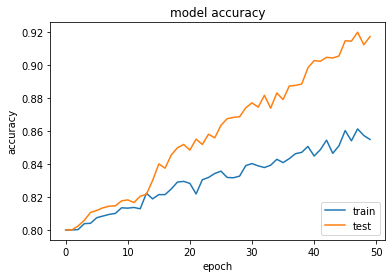

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()




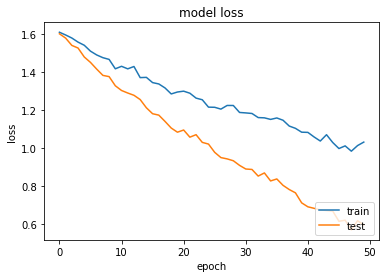

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

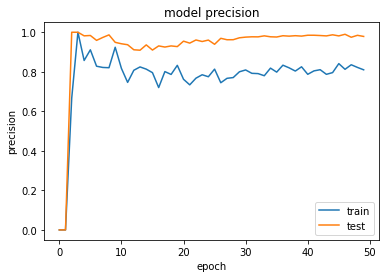

In [68]:
plt.plot(history.history['precision_4'])
plt.plot(history.history['val_precision_4'])

plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

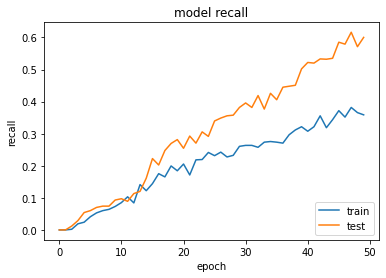

In [69]:
plt.plot(history.history['recall_3'])
plt.plot(history.history['val_recall_3'])

plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [32]:
import tensorflow

# import the trained model

model_path = '/home/charun/Documents/Projects/text_research/new_text_model1.h5'
model = tensorflow.keras.models.load_model(model_path)

In [33]:
df_eval = pd.read_excel('/home/charun/Documents/Projects/text_research/eval_data.xlsx')

In [34]:
#convert our labels into numerical values. in here we add 0 for the User Interface, 1 for the debug and
# 2 for the document and text

df_eval['Label'] = df_eval['label'].replace(['User Interface', 'Debug','Document and text', 'Integration', 'Core' ], [0,1,2,3,4])

#after that we drop the column which contains the textual labels

new_df_eval = df_eval.drop(columns=['label'])
new_df_eval['Label'].unique()

array([1, 0, 3, 4, 2])

In [35]:
# preprocess our evaluation dataset


def form_sentence(tweet):
    tweet = re.sub(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", '', tweet)
    tweet = re.sub(r'<[^>]+>', '', tweet)
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', tweet)
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)


def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess


def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word, 'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet


Final_words_eval = [] 



for data in new_df_eval['text']:
    filtered = normalization(no_user_alpha(form_sentence(data)))
    word_Final = ' '.join(filtered)
    Final_words_eval.append(word_Final)
    


# store preprocessed data to new dataframe called final_bodyTrain    
    
final_body_eval = pd.DataFrame(Final_words_train, columns=['body'])


In [37]:
token = Tokenizer()
token.fit_on_texts(final_body_eval['body'])

#integer encode the documents
seq = token.texts_to_sequences(final_body_eval['body'])

# pad the document

max_length = 100
pad_seq = pad_sequences(seq, maxlen=max_length, padding='post')


In [38]:
#predict the result using the trained model

pred = model.predict(pad_seq)
pred

array([[0.15741694, 0.41862983, 0.01163317, 0.3218309 , 0.0904891 ],
       [0.65723926, 0.04766425, 0.12399331, 0.04522521, 0.12587804],
       [0.05830264, 0.7350734 , 0.00386232, 0.16260813, 0.04015345],
       ...,
       [0.22474867, 0.174095  , 0.13077545, 0.13418965, 0.33619124],
       [0.77369153, 0.04771454, 0.02924141, 0.02706683, 0.12228565],
       [0.30155584, 0.1169453 , 0.15155444, 0.12283603, 0.30710837]],
      dtype=float32)

In [39]:
# get the label class

classes = np.argmax(pred, axis = 1)
print(classes)

[1 0 1 3 0 1 4 2 2 1 1 4 2 3 1 0 3 1 4 0 0 3 4 4 4 3 2 4 4 0 0 3 0 4 0 0 3
 3 4 3 4 4 1 0 4 2 0 0 0 1 0 2 4 0 2 4 0 1 1 4 3 3 2 3 4 3 0 4 3 4 4 0 4 4
 1 4 4 4 1 4 1 0 2 1 1 2 0 1 0 4 3 2 2 1 0 0 0 1 1 1 1 3 0 0 1 1 0 1 1 3 3
 1 4 4 2 0 3 4 1 2 4 0 3 2 2 2 2 0 4 4 0 2 0 2 1 3 2 0 3 1 0 4 4 2 3 1 2 4
 0 1 1 4 0 4 2 2 3 2 4 2 2 2 0 4 0 2 0 2 4 0 1 4 2 4 3 3 0 4 2 0 2 4 0 1 0
 3 0 4 2 1 2 3 0 1 1 1 2 1 1 4 3 3 0 3 0 4 0 2 3 2 3 4 1 3 3 0 0 1 1 2 4 2
 4 3 0 1 4 2 4 4 0 0 1 4 3 4 4 4 0 0 0 1 0 2 2 4 2 2 3 2 0 1 4 3 4 1 1 1 4
 1 3 4 4 2 0 2 1 1 2 3 4 2 3 0 2 3 2 3 4 3 3 3 0 0 1 4 2 1 1 2 0 1 0 4 1 0
 4 0 1 4 2 3 4 2 4 4 3 2 2 1 2 0 0 0 3 0 0 1 1 3 3 2 4 1 3 4 0 1 4 2 4 4 3
 2 0 2 0 0 0 2 4 0 0 4 0 2 3 2 4 1 2 3 4 4 1 4 3 1 0 1 3 3 3 2 2 2 1 0 1 3
 0 2 3 2 4 1 0 0 1 1 4 2 4 0 1 1 2 0 3 0 0 0 2 4 2 1 2 3 4 2 4 4 4 3 4 4 3
 1 1 4 1 4 0 1 2 1 4 3 3 1 2 2 2 0 2 1 4 2 1 0 2 0 4 4 3 1 2 4 3 2 4 1 4 4
 2 2 3 4 2 4 3 0 1 2 0 1 3 4 0 0 0 0 0 4 4 2 1 4 2 2 2 0 4 1 3 0 1 2 4 1 0
 4 4 4 0 4 2 3 4 1 1 1 0 

In [62]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, f1_score,classification_report, accuracy_score
import itertools
import matplotlib.pyplot as plt

In [41]:
# f1 score
print(f1_score(new_df_eval['Label'], classes , average="macro"))


0.8552517546899242


In [74]:
print('accuracy for the evaluation dataset is {}'.format(accuracy_score(y_true=new_df_eval['Label'], y_pred=classes, normalize=True)))

accuracy for the evaluation dataset is 0.8547094188376754


In [67]:
target_names = ['User Interface', 'Debug','Document and text', 'Integration', 'Core']

In [68]:
print(classification_report(y_true=new_df_eval['Label'], y_pred=classes, target_names=target_names))

                   precision    recall  f1-score   support

   User Interface       0.76      0.79      0.78       195
            Debug       0.91      0.87      0.89       194
Document and text       0.93      0.95      0.94       204
      Integration       0.91      0.82      0.87       200
             Core       0.78      0.83      0.80       205

         accuracy                           0.85       998
        macro avg       0.86      0.85      0.86       998
     weighted avg       0.86      0.85      0.86       998



In [42]:
cm = confusion_matrix(y_true=new_df_eval['Label'], y_pred=classes)

In [56]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
# plotting the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [50]:
cm_plot_labels = ['User Interface', 'Debug','Document and text', 'Integration', 'Core']

Confusion matrix, without normalization
[[155   3   2   7  28]
 [ 11 169   0   5   9]
 [  4   1 194   3   2]
 [ 11   6   8 165  10]
 [ 23   6   5   1 170]]


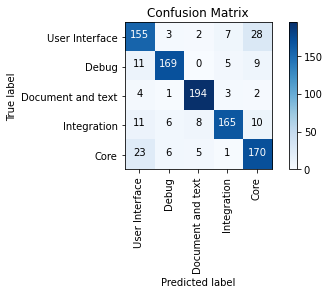

In [57]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')